# Exploratory data analysis using Kallisto data
transcripts per million output was obtained from cluster

# Table of Contents
* <a href='#Importing-necessary-things'>Importing necessary things</a>
Also placing functions that we will use later
* <a href='#Looking at a single file'>Looking at a single file</a>
In this section we plot a histogram of the log values of a typical file.  
* <a href='#Using all files'>Using all files</a>
We look at all the files. We also plot descriptions of the log values of two kind of weird files (Zi238_C4 and FR188_T3).  These weird files had also shown up as outliers in a PCA plot (not shown).  Zi238 was a very clear outlier, then FR188_T3.  We just removed both of them
* <a href='#Preliminary PCA non logged'>Preliminary PCA non logged</a> We see here that T and C cluster together, but not much else.  If we were to look at testes only data or carcass only data with this non-logged data, we don't see any clustering by line or country, even on 2nd and 3rd components (not plotted)
* <a href='#Preliminary PCA logged'>Preliminary PCA logged</a> Same results as above when cutoffs of 0, .1 and .01 TPM applied.
* <a href='#Carcass only data'>Carcass only data</a> Here we look at carcass only data on logged data.  Can't see any clustering by country or line, even when cutoffs of .1 and .01 TPM applied.
* <a href='#Testes only data'>Testes only data</a> Here we look at carcass only data on logged data. Can't see any clustering by country or line, even when cutoffs of .1 and .01 TPM applied.
* <a href='#Using Regularized Data'>Using Regularized Data</a>


<a id='Importing-necessary-things'></a>
##Importing necessary things

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from sklearn.decomposition import PCA
import glob
import string

In [2]:
def applyLabels(LoadedData, pca, country=True, TorC=True, lineLabels=True):
    dictOfLabels={}
    if TorC:
        TorClabels=[a.split('_')[1][0] for a in LoadedData.columns]
        dictOfLabels["TorC"]=TorClabels
    if lineLabels:
        lineLabels=[filter(str.isdigit,a.split('_')[0]) for a in LoadedData.columns]
        dictOfLabels["lines"]=lineLabels
    if country:
        countryLabels=[a[:2] for a in LoadedData.columns]
        dictOfLabels["country"]=countryLabels
    dfPCA=pd.DataFrame(dictOfLabels)
    for i in range(pca.explained_variance_ratio_.shape[0]):
        dfPCA["pc%i" % (i+1)] = X[:,i]
    return dfPCA


def plot_PCA(labelName, df, firstComponent="pc1", secondComponent="pc2"):
    plt.figure()
    colors=["red","blue","yellow", "green"]
    for label, color in zip(df[labelName].unique(), colors):
        mask = df[labelName]==label
        plt.scatter(df[mask][firstComponent], df[mask][secondComponent], c=color, label=label)
    plt.legend()
    plt.title(labelName +" PCA plot")
    plt.xlabel(firstComponent)
    plt.ylabel(secondComponent)
    plt.show()

<a id='Looking at a single file'></a>
###Looking at a single file

In [3]:
Fr188_C1=pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/results2/Fr188_C1_TTAGGC/abundance.tsv",sep="\t")



In [5]:
Fr188_C1.head()
Fr188_C1.iloc[21457]

target_id     FBtr0306916
length                853
eff_length            554
est_counts             17
tpm               1.77855
Name: 21457, dtype: object

Checking that tpm sum up to 1000000

In [6]:
sum(Fr188_C1.tpm) , len(Fr188_C1)

(999999.86039515177, 30433)

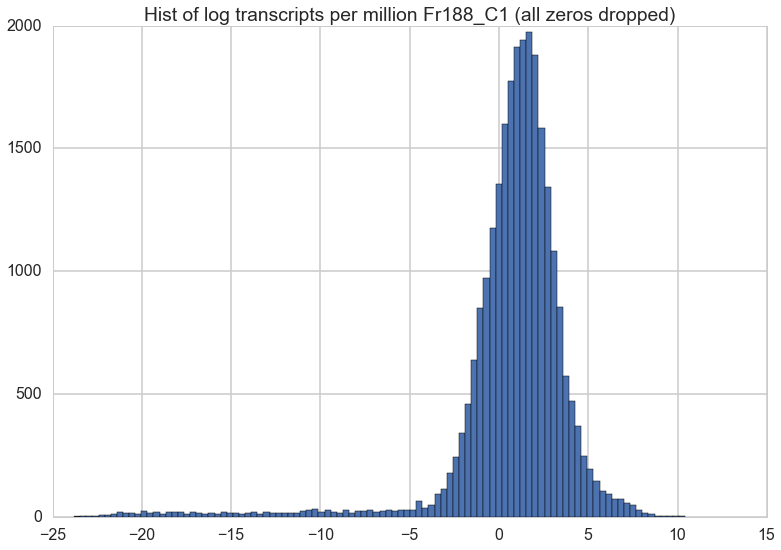

In [7]:
plt.hist(np.log(Fr188_C1[Fr188_C1.tpm>0].tpm), bins=100)
plt.title("Hist of log transcripts per million Fr188_C1 (all zeros dropped)")
plt.show()

Now plotting the weird outliers that showed up when we naively tried PCA.  We can tell that our data for Zi238_C4 is wrong -- too many zeros!  It also looks like Fr188_T3 might have a little bit of an excess of zeros, though it's not as terrible as Zi238.

<a id='Using all files'></a>
#Looking at the output of all Kallisto files

In [8]:
#Create a dataframe with tpm data from all files
files_dict={}
files_dict2={}

for fl in glob.glob("../KallistoFiles/results2/*"):
    a= string.join(fl.split('/')[3].split('_')[:2], sep="_")
    if a:
        files_dict[a]=pd.read_csv(fl+"/abundance.tsv", sep="\t").tpm
        files_dict2[a]=pd.read_csv(fl+"/abundance.tsv", sep="\t").est_counts

LoadedData=pd.DataFrame(files_dict)
LoadedData2=pd.DataFrame(files_dict2)

LoadedData2.head()

,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5,Zi238_C1,Zi238_C2,Zi238_C3,Zi238_C4,Zi238_T2,Zi238_T3,Zi238_T4,Zi257_C1,Zi257_C2,Zi257_C3,Zi257_T1,Zi257_T2,Zi257_T3,Zi257_T4
0,33.3221,47.8248,9.500280,0.0000,0.0000,0.0000,18.3605,26.4938,9.48811,0.0000,8.86619,0.00,18.3069,8.41112,28.7241,0,9.284380,0.0000,9.23451,0.0000,9.53937,9.48031,0.0000,9.54134,0.0000,0.000
1,179.1930,143.9690,75.708400,91.0000,410.9200,194.0820,402.9420,309.2880,42.97700,409.7400,209.65000,282.00,177.0750,61.61910,37.7433,0,225.715000,134.5820,266.98900,95.8937,129.46100,144.83800,319.0900,417.45900,258.1040,255.000
2,140.4370,49.8132,0.000000,0.0000,0.0000,24.9176,67.2137,20.2182,172.84200,0.0000,0.00000,0.00,88.6302,17.96980,174.5330,0,0.000000,0.0000,22.77670,99.1063,0.00000,98.68130,22.9097,0.00000,24.8956,0.000
3,39.0488,10.3929,0.791355,0.0000,30.0801,0.0000,31.4841,0.0000,34.69310,14.2605,21.48430,0.00,13.9875,0.00000,0.0000,0,0.000219,13.4176,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0.000
4,106.0950,20.7158,22.194600,72.0892,292.5320,191.3280,71.1422,26.3617,32.44660,316.6900,167.52100,177.06,79.3580,23.68770,97.3252,0,189.870000,158.1670,253.02200,30.0000,27.86390,47.23410,213.2130,267.68800,277.1740,101.469


In [9]:
LoadedData2.apply(sum)

Fr188_C1    13857862.885476
Fr188_C2     8016618.895483
Fr188_C3     3509362.142211
Fr188_T3     3452912.056923
Fr188_T5    11434116.516900
Fr188_T6     7210509.955261
Fr89_C1      9022363.876161
Fr89_C2      8297441.498479
Fr89_C4      8371535.833787
Fr89_T3     13877636.582930
Fr89_T4      7832838.921492
Fr89_T5      8719186.105957
Zi238_C1     8653643.619012
Zi238_C2     2783701.967342
Zi238_C3     7168519.925971
Zi238_C4          57.999999
Zi238_T2     7370849.027603
Zi238_T3     5260320.021763
Zi238_T4     9151181.026954
Zi257_C1     4514294.835693
Zi257_C2     3753478.778057
Zi257_C3     5801693.758632
Zi257_T1     8856750.662136
Zi257_T2    11728204.393123
Zi257_T3     9858229.282826
Zi257_T4     6169549.622757
dtype: float64

In [10]:
max(LoadedData.Fr188_C1)
LoadedData[LoadedData.Fr188_C1==max(LoadedData.Fr188_C1)]


,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5,Zi238_C1,Zi238_C2,Zi238_C3,Zi238_C4,Zi238_T2,Zi238_T3,Zi238_T4,Zi257_C1,Zi257_C2,Zi257_C3,Zi257_T1,Zi257_T2,Zi257_T3,Zi257_T4
23217,33566,18760,29714.2,0,5.87509,2.83382,21386,18343.1,34644.3,4.59172,0,2.98541,25273.5,20266.3,21349.6,0,2.29297,3.92122,4.95532,24508.2,22859.8,27084.2,6.513,0,4.06049,0


Fr188_C1     4500
Fr188_C2     5084
Fr188_C3     7060
Fr188_T3     8991
Fr188_T5     5993
Fr188_T6     6991
Fr89_C1      4897
Fr89_C2      6074
Fr89_C4      5015
Fr89_T3      5614
Fr89_T4      6565
Fr89_T5      6628
Zi238_C1     4938
Zi238_C2     7281
Zi238_C3     5670
Zi238_C4    30362
Zi238_T2     7024
Zi238_T3     7775
Zi238_T4     6368
Zi257_C1     7449
Zi257_C2     8197
Zi257_C3     6910
Zi257_T1     6866
Zi257_T2     5921
Zi257_T3     6511
Zi257_T4     7341
dtype: int64


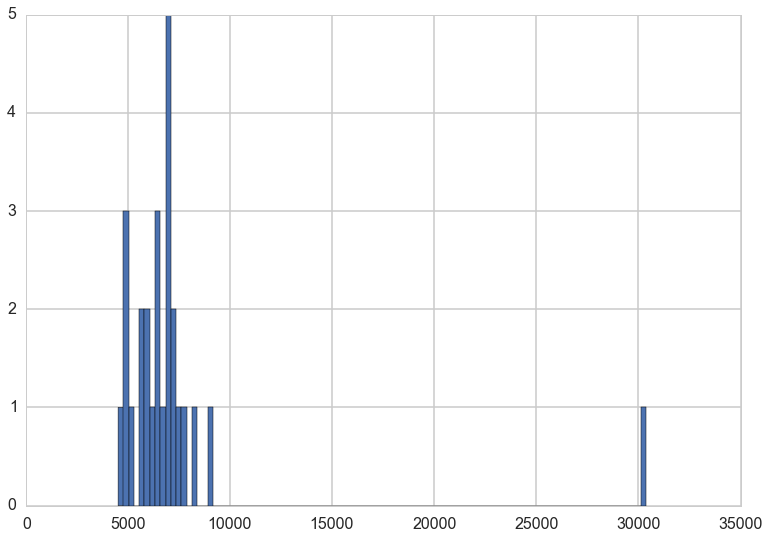

In [11]:
#Seeing how many zeros there are for each column
print LoadedData.apply(func=lambda x: len(x[x==0]), axis=0)
LoadedData.apply(func=lambda x: len(x[x==0]), axis=0).hist(bins=100)

We can see from the above plots that Zi238 is a clear outlier.  Fr188_T3 is sortof outlier-ish.  We now look at these files in more detail.

Zi238_C4              length    eff_length    est_counts            tpm
count  30433.000000  30433.000000  30433.000000   30433.000000
mean    2881.369993   2582.617209      0.001906      32.859058
std     2923.665970   2923.445876      0.043601    2294.529999
min      108.000000      5.010910      0.000000       0.000000
25%     1250.000000    951.000000      0.000000       0.000000
50%     2154.000000   1855.000000      0.000000       0.000000
75%     3634.000000   3335.000000      0.000000       0.000000
max    71382.000000  71083.000000      2.000000  386717.000000

Fr188_T3              length    eff_length    est_counts            tpm
count  30433.000000  30433.000000  30433.000000   30433.000000
mean    2881.369993   2542.849909    113.459470      32.859062
std     2923.665970   2923.243924    544.137509    1411.308515
min      108.000000      4.288320      0.000000       0.000000
25%     1250.000000    911.000000      0.000000       0.000000
50%     2154.000000   1815.000000   

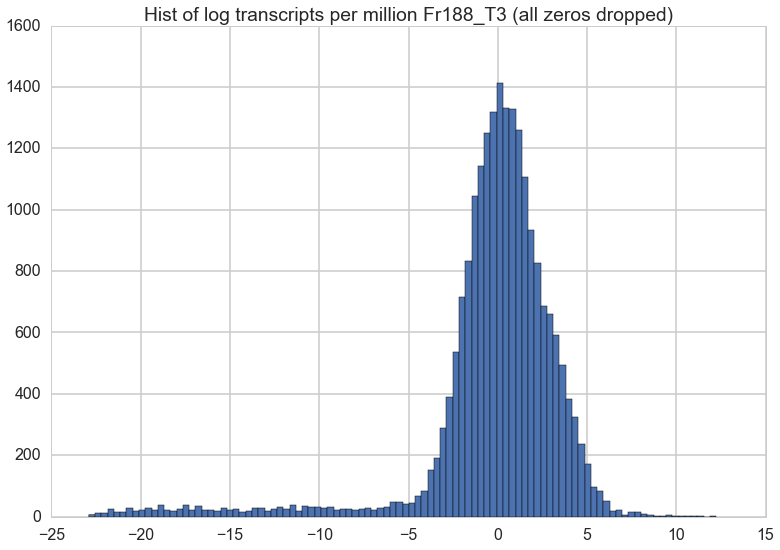

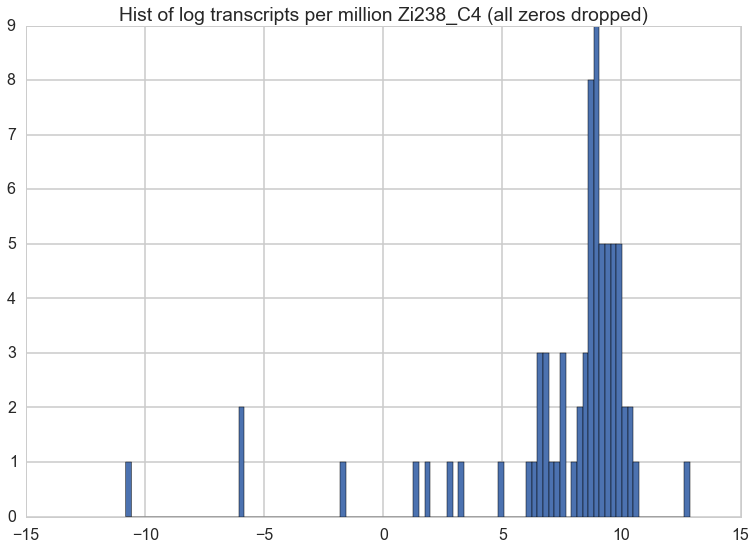

In [12]:
Zi238_C4 =pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/results2/Zi238_C4_AGTTCC/abundance.tsv",sep="\t")
print "Zi238_C4", Zi238_C4.describe()
print

Fr188_T3=pd.read_csv("/Users/leandraking/Desktop/KallistoFiles/results2/Fr188_T3_GTCCGC/abundance.tsv",sep="\t")
print "Fr188_T3", Fr188_T3.describe()

plt.hist(np.log(Fr188_T3[Fr188_T3.tpm>0].tpm).values, bins=100)
plt.title("Hist of log transcripts per million Fr188_T3 (all zeros dropped)")
plt.show()

plt.hist(np.log(Zi238_C4[Zi238_C4.tpm>0].tpm).values, bins=100)
plt.title("Hist of log transcripts per million Zi238_C4 (all zeros dropped)")
plt.show()

In [13]:
#Deleting initial weird outliers (these showed up in PCA as outliers).  
del LoadedData["Zi238_C4"]
del LoadedData["Fr188_T3"] 

In [14]:
LoadedData.head()
#len(LoadedData)

,Fr188_C1,Fr188_C2,Fr188_C3,Fr188_T5,Fr188_T6,Fr89_C1,Fr89_C2,Fr89_C4,Fr89_T3,Fr89_T4,Fr89_T5,Zi238_C1,Zi238_C2,Zi238_C3,Zi238_T2,Zi238_T3,Zi238_T4,Zi257_C1,Zi257_C2,Zi257_C3,Zi257_T1,Zi257_T2,Zi257_T3,Zi257_T4
0,0.396254,0.906734,0.332550,0.000000,0.000000,0.261485,0.494459,0.148762,0.000000,0.061694,0.00000,0.267718,0.477455,0.662059,0.111964,0.000000,0.059634,0.00000,0.385866,0.197856,0.000000,0.050108,0.000000,0.00000
1,2.378830,3.048270,2.961890,2.915680,1.992730,6.410930,6.446240,0.753211,2.194150,1.630310,2.84654,2.892140,3.905330,0.971394,3.037040,1.934810,1.926290,2.97333,5.849900,3.379260,2.185810,2.449020,1.812440,3.36559
2,1.789730,1.012350,0.000000,0.000000,0.245572,1.026310,0.404474,2.906530,0.000000,0.000000,0.00000,1.389410,1.093260,4.311770,0.000000,0.000000,0.157706,2.94866,0.000000,2.209030,0.150556,0.000000,0.167798,0.00000
3,0.629034,0.267217,0.037657,0.259156,0.000000,0.608744,0.000000,0.739792,0.092738,0.203182,0.00000,0.277478,0.000000,0.000000,0.000004,0.234208,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,1.691220,0.527044,1.044970,2.493880,2.360270,1.361040,0.660203,0.684547,2.037860,1.567520,2.14798,1.557730,1.803210,3.009130,3.064420,2.731910,2.195390,1.11945,1.513820,1.326870,1.759530,1.888040,2.338950,1.60810


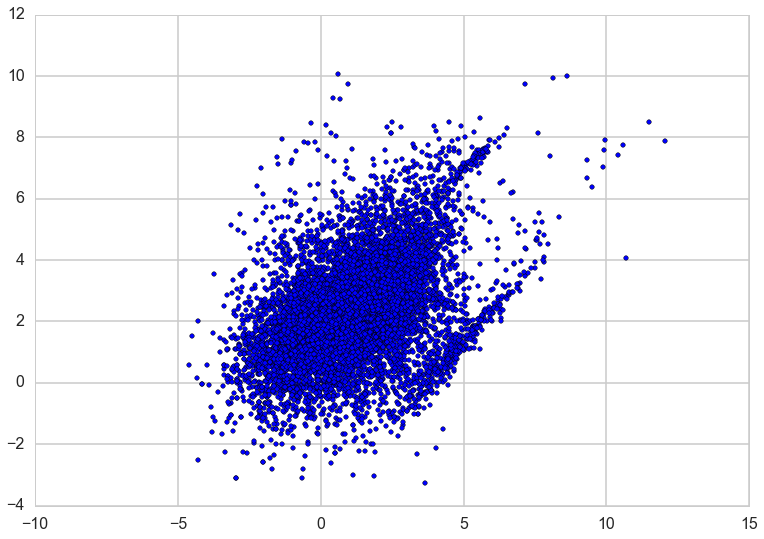

In [25]:
plt.scatter(LoadedDataLog.Fr188_T5, LoadedDataLog.Fr188_C2)

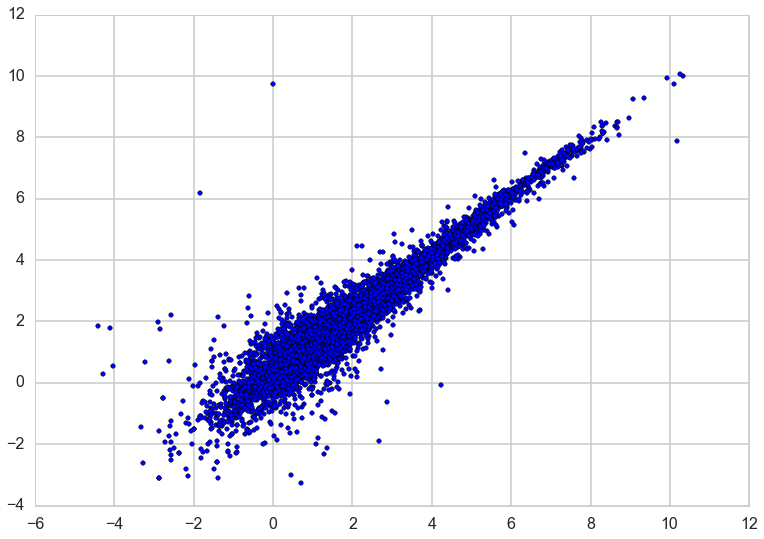

In [24]:
plt.scatter(LoadedDataLog.Fr188_C3, LoadedDataLog.Fr188_C2)

<a id='Preliminary PCA non logged'></a>
###Do a PCA (non logged data)

In [18]:
pca = PCA(n_components=50)
X = pca.fit_transform(LoadedData.transpose())
pca.explained_variance_ratio_.sum()

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


1.0000000000000002

In [19]:
pca.explained_variance_ratio_*100

array([  9.07809238e+01,   5.11786103e+00,   1.52016179e+00,
         1.26435709e+00,   4.91990440e-01,   2.40619000e-01,
         1.46264282e-01,   1.25944275e-01,   8.08936332e-02,
         5.33667082e-02,   4.61734600e-02,   3.53184931e-02,
         2.71328924e-02,   1.49866456e-02,   1.01159708e-02,
         8.93446173e-03,   7.89981317e-03,   7.10397842e-03,
         6.31768727e-03,   4.79072526e-03,   4.11446141e-03,
         2.80567921e-03,   1.92367813e-03,   5.75102008e-30])

The variance is really explained here by the first two components

In [20]:
#Applying labels to dataframe
dfPCA=applyLabels(LoadedData, pca)

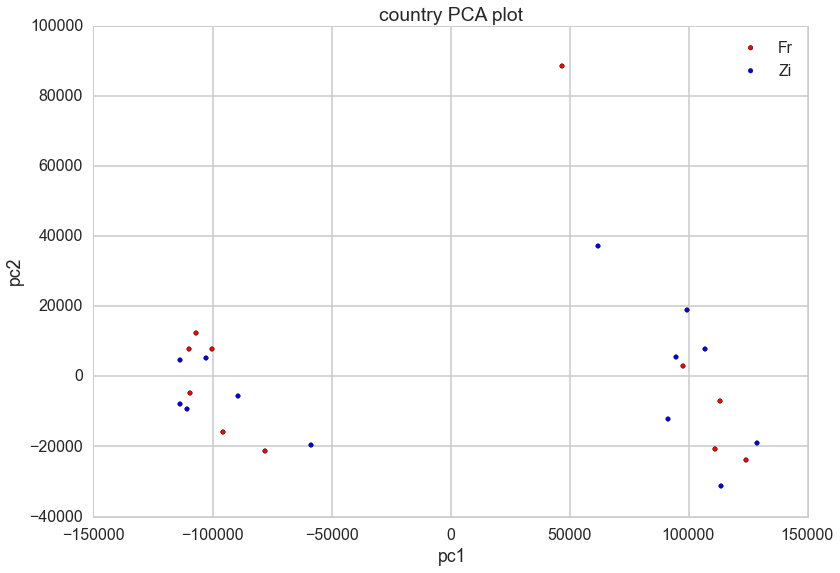

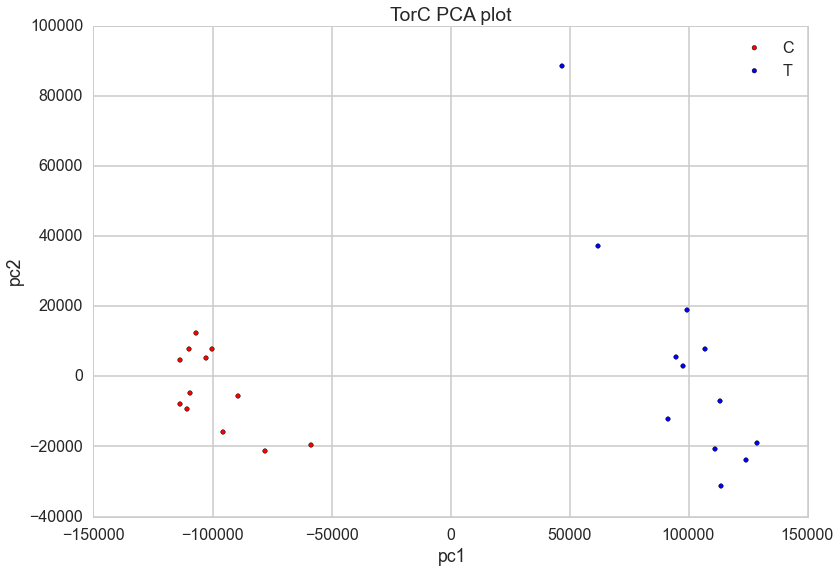

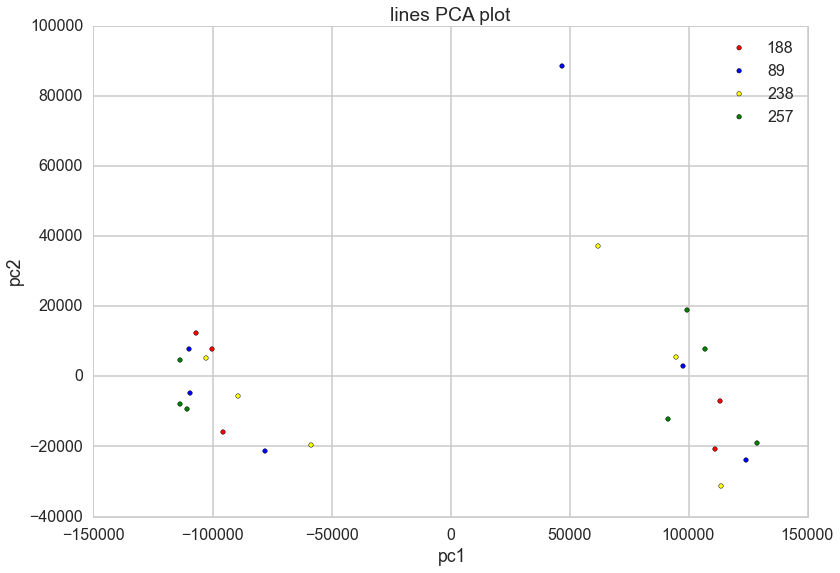

In [21]:
plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Carcass points cluster together.  Lines do not cluster together, nor do countries.  No clear outliers.

<a id='Preliminary PCA logged'></a>
##Taking log of the data

We replace all 0 values by 1/1million.  We also try various cutoffs.

In [26]:
cutoff=0.01
LoadedDataLog=LoadedData.replace(0, 1e-06)
mask= LoadedDataLog.apply(lambda x : (x > cutoff))
LoadedDataLog=LoadedDataLog[mask.all(axis=1)]

LoadedDataLog=LoadedDataLog.apply(np.log)

pca = PCA(n_components=50)
X = pca.fit_transform(LoadedDataLog.transpose())
pca.explained_variance_ratio_.sum()

0.99999999999999978

In [27]:
pca.explained_variance_ratio_*100

array([  8.88249376e+01,   2.64226898e+00,   1.18832256e+00,
         7.32749052e-01,   7.02427206e-01,   5.84543073e-01,
         4.79239615e-01,   4.59130551e-01,   4.39932638e-01,
         4.13265888e-01,   3.88663416e-01,   3.59934854e-01,
         3.52898977e-01,   3.39757811e-01,   2.98549341e-01,
         2.76984930e-01,   2.55863831e-01,   2.40313891e-01,
         2.28336345e-01,   2.12452261e-01,   2.09315999e-01,
         2.03610618e-01,   1.66500563e-01,   1.39896575e-29])

In [28]:
#Applying labels to dataframe
dfPCA=applyLabels(LoadedDataLog, pca)

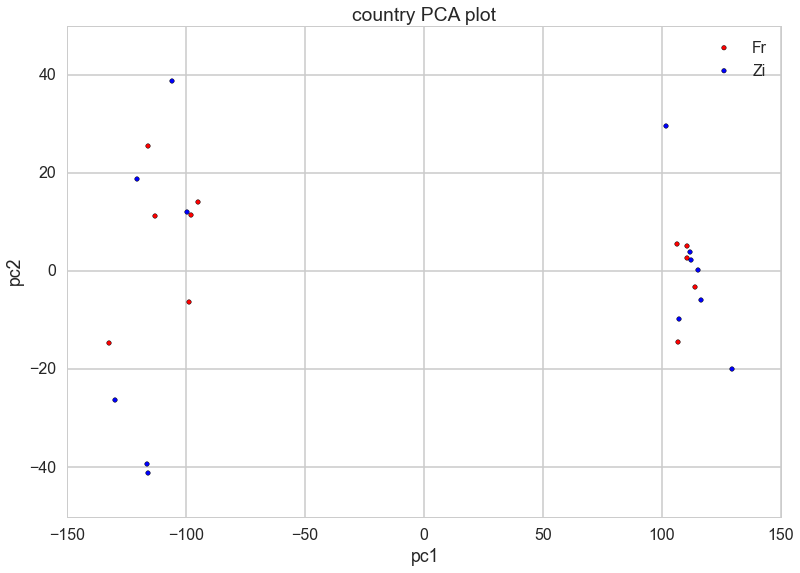

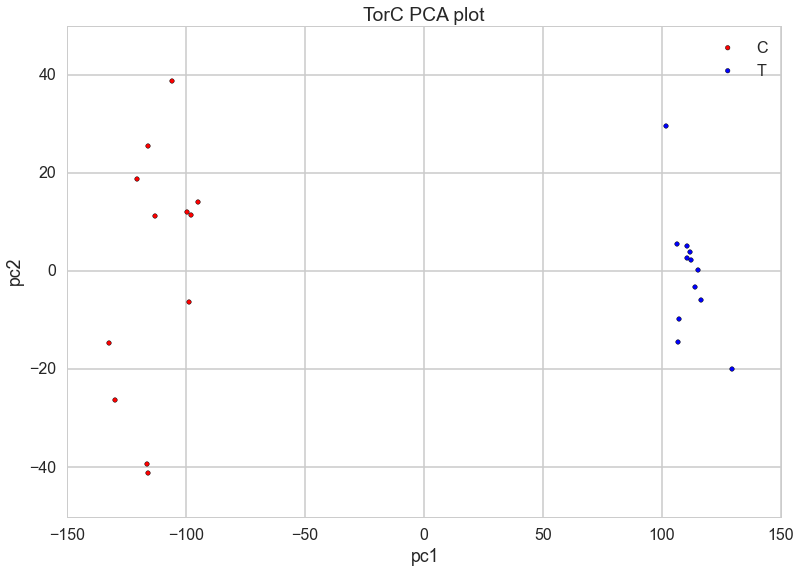

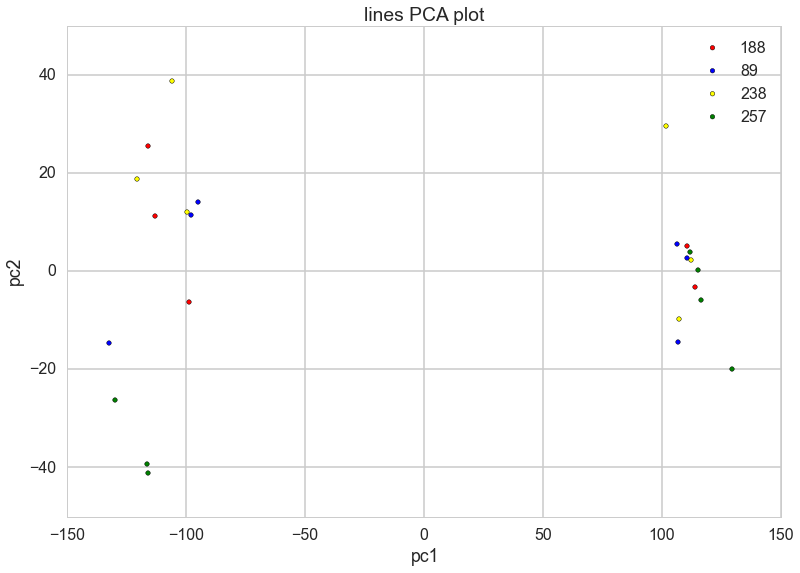

In [29]:
plot_PCA("country",dfPCA)
plot_PCA("TorC", dfPCA)
plot_PCA("lines",dfPCA)

Plotting PC2 vs PC3 -- can't see much clustering there either.

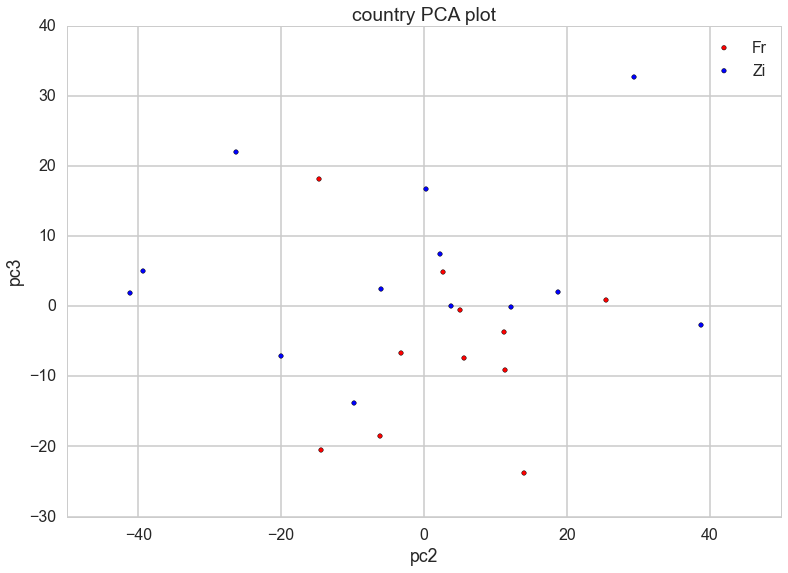

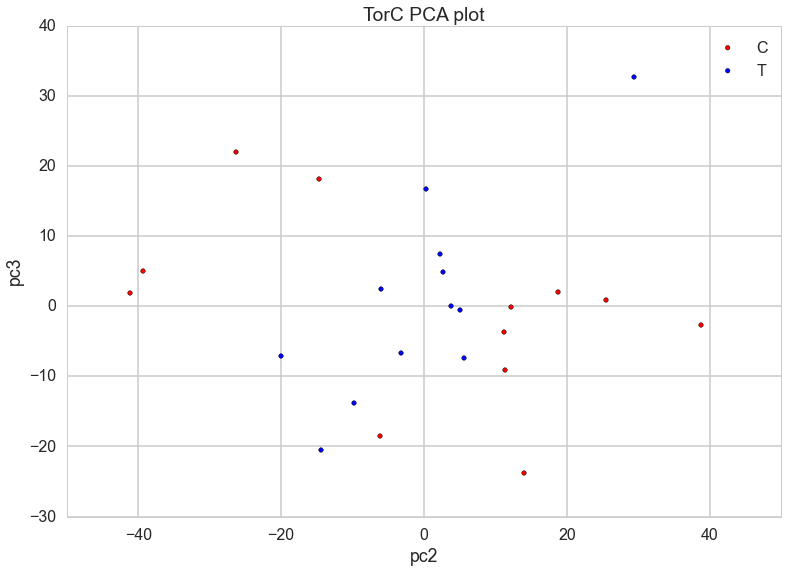

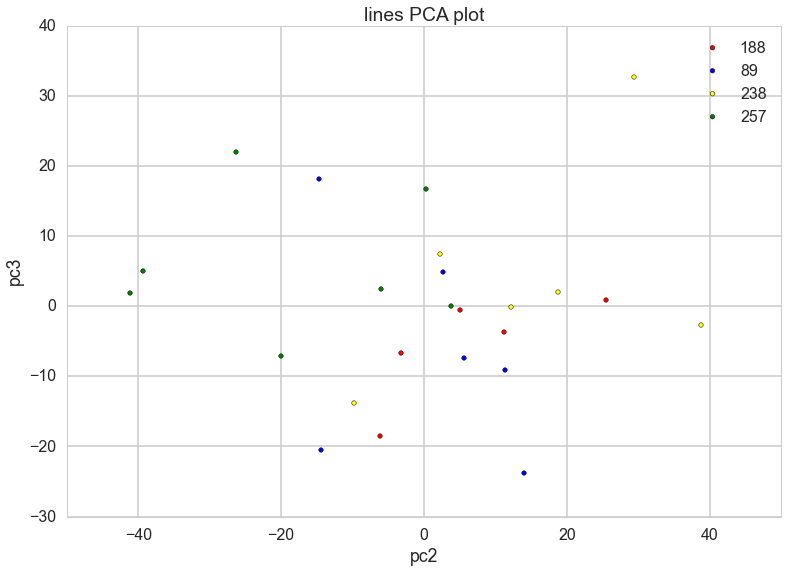

In [30]:
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("TorC", dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")

<a id='Carcass only data'></a>

#Carcass only data

In [31]:
#Create carcass dataframe on logged dataframe
TorClabels=[a.split('_')[1][0] for a in LoadedDataLog.columns]
dfCarcass=LoadedDataLog[[col for lab,col in zip(TorClabels,LoadedDataLog.columns) if lab=="C"]]
pca = PCA(n_components=20)
X = pca.fit_transform(dfCarcass.transpose())
pca.explained_variance_ratio_*100

array([  3.66389505e+01,   1.57483698e+01,   1.01161603e+01,
         7.03268786e+00,   6.42853801e+00,   6.04907927e+00,
         4.79141520e+00,   3.95210884e+00,   3.42592233e+00,
         3.27677937e+00,   2.53998843e+00,   7.02504910e-29])

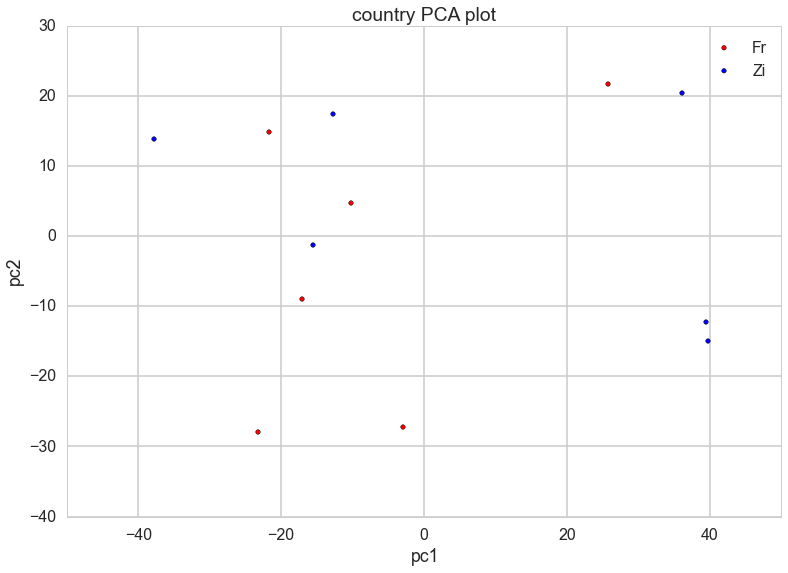

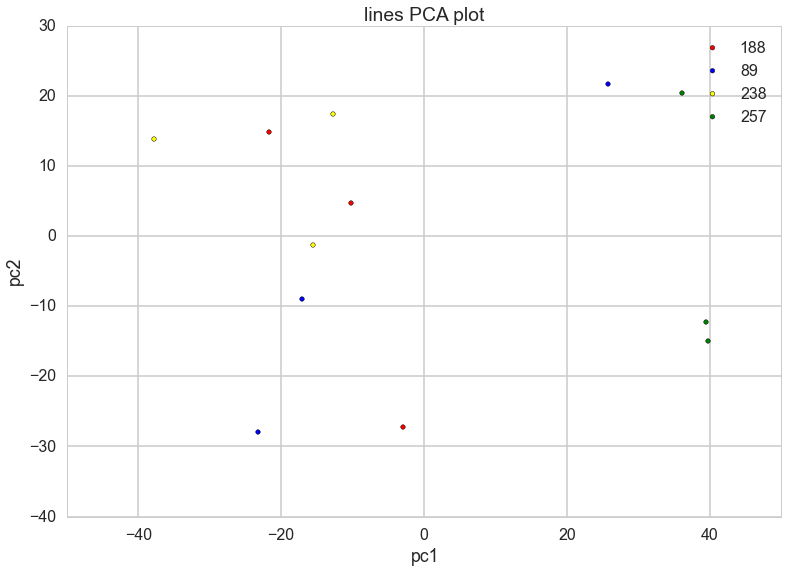

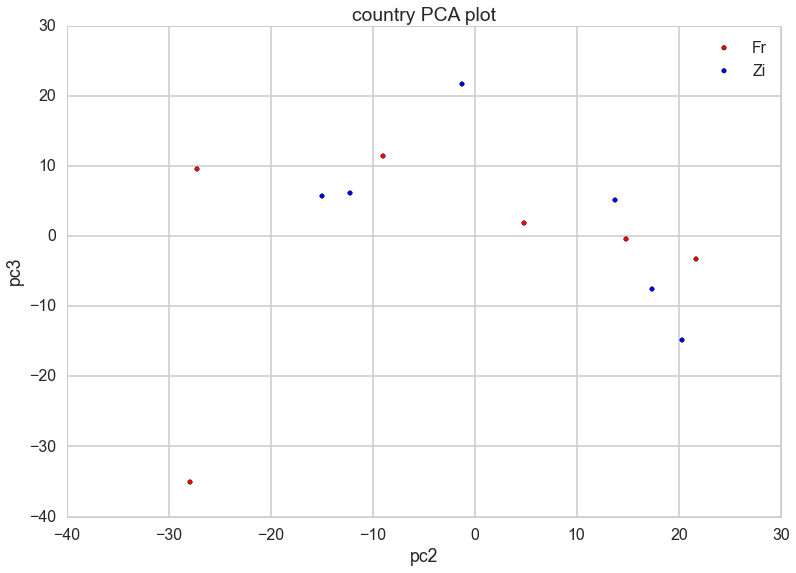

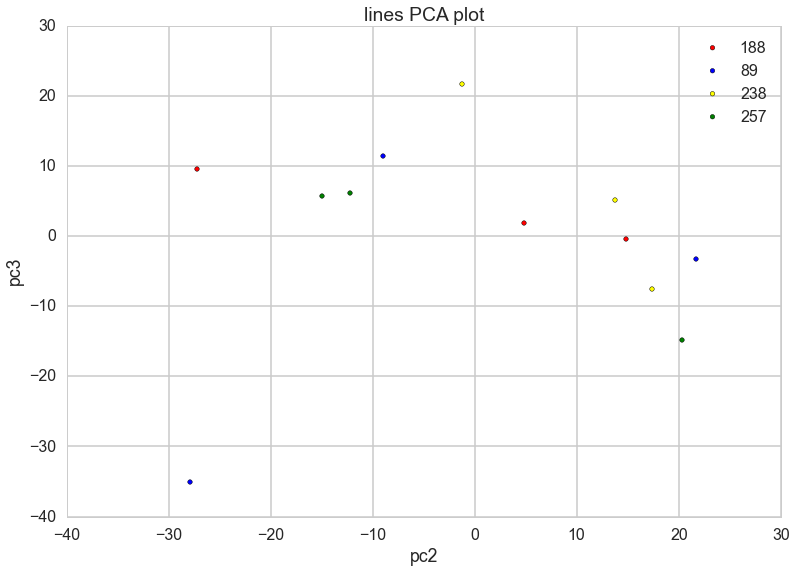

In [32]:
dfPCA=applyLabels(dfCarcass, pca, TorC=False)
plot_PCA("country",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("lines",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")

<a id='Testes only data'></a>

#Testes only data

In [33]:
#Create carcass dataframe on logged dataframe
TorClabels=[a.split('_')[1][0] for a in LoadedDataLog.columns]
dfTestes=LoadedDataLog[[col for lab,col in zip(TorClabels,LoadedDataLog.columns) if lab=="T"]]
pca = PCA(n_components=20)
X = pca.fit_transform(dfTestes.transpose())
pca.explained_variance_ratio_*100

array([  2.38537739e+01,   1.53271087e+01,   1.04713758e+01,
         9.06144085e+00,   7.99192837e+00,   7.33166073e+00,
         6.60870567e+00,   6.03598593e+00,   4.69857540e+00,
         4.35407217e+00,   4.26537251e+00,   1.10159543e-28])

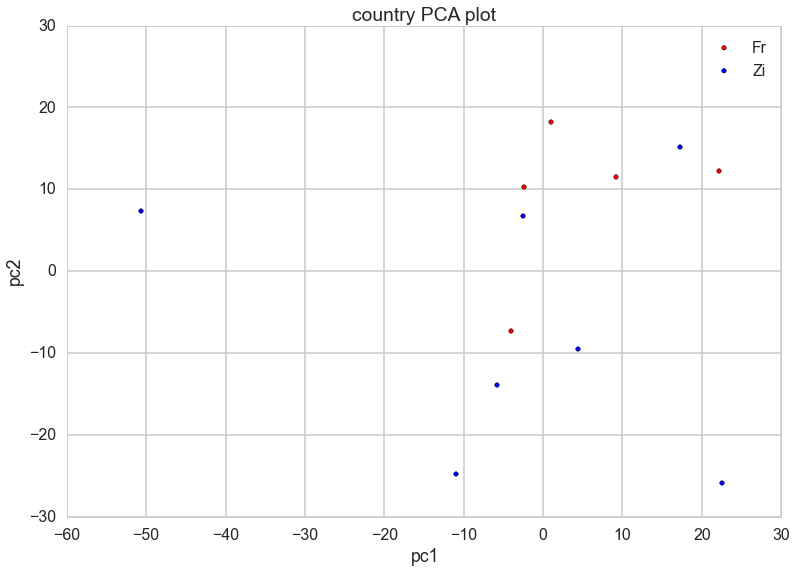

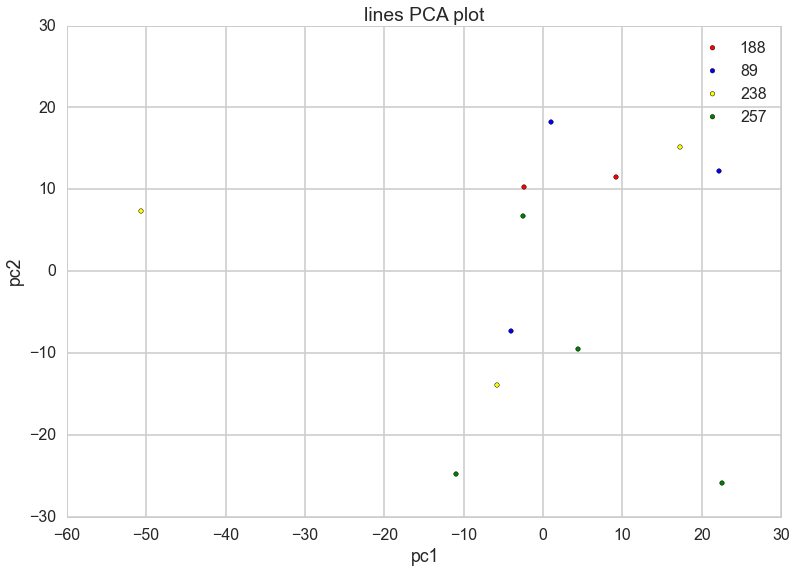

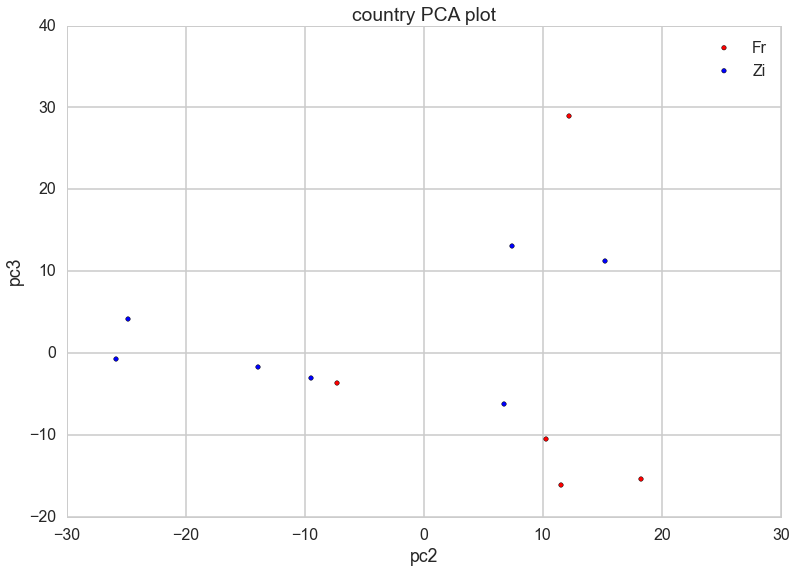

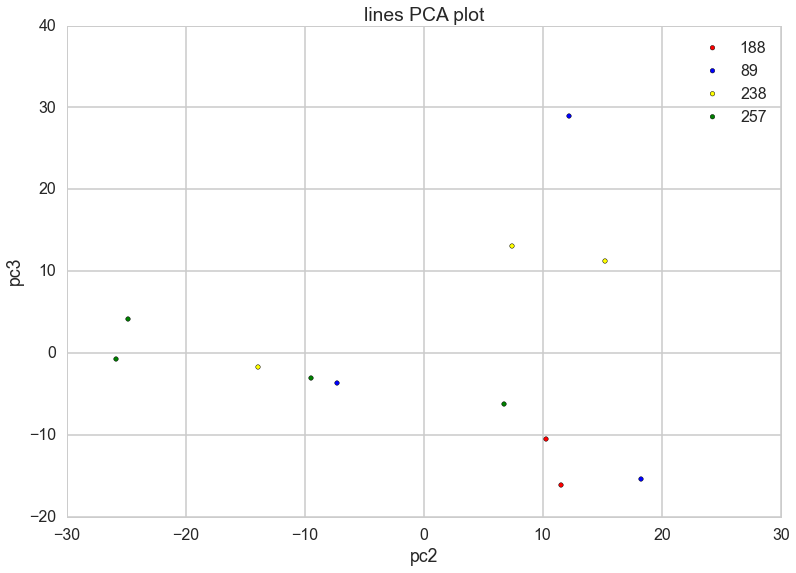

In [34]:
dfPCA=applyLabels(dfTestes, pca, TorC=False)
plot_PCA("country",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("lines",dfPCA, firstComponent="pc1", secondComponent="pc2")
plot_PCA("country",dfPCA, firstComponent="pc2", secondComponent="pc3")
plot_PCA("lines",dfPCA, firstComponent="pc2", secondComponent="pc3")

<a id='Using Regularized Data'></a>
##Using regularized data

In [40]:
### hierarchical_clustering.py
#Copyright 2005-2012 J. David Gladstone Institutes, San Francisco California
#Author Nathan Salomonis - nsalomonis@gmail.com

#Permission is hereby granted, free of charge, to any person obtaining a copy 
#of this software and associated documentation files (the "Software"), to deal 
#in the Software without restriction, including without limitation the rights 
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell 
#copies of the Software, and to permit persons to whom the Software is furnished 
#to do so, subject to the following conditions:

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
#INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
#PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
#HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
#OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
#SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

#################
### Imports an tab-delimited expression matrix and produces and hierarchically clustered heatmap
#################

import matplotlib.pyplot as pylab
from matplotlib import mpl
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
import numpy
import string
import time
import sys, os
import getopt

################# Perform the hierarchical clustering #################

def heatmap(x, row_header, column_header, row_method,
            column_method, row_metric, column_metric,
            color_gradient, filename):
    
    print "\nPerforming hiearchical clustering using %s for columns and %s for rows" % (column_metric,row_metric)
        
    """
    This below code is based in large part on the protype methods:
    http://old.nabble.com/How-to-plot-heatmap-with-matplotlib--td32534593.html
    http://stackoverflow.com/questions/7664826/how-to-get-flat-clustering-corresponding-to-color-clusters-in-the-dendrogram-cre

    x is an m by n ndarray, m observations, n genes
    """
    
    ### Define the color gradient to use based on the provided name
    n = len(x[0]); m = len(x)
    if color_gradient == 'red_white_blue':
        cmap=pylab.cm.bwr
    if color_gradient == 'red_black_sky':
        cmap=RedBlackSkyBlue()
    if color_gradient == 'red_black_blue':
        cmap=RedBlackBlue()
    if color_gradient == 'red_black_green':
        cmap=RedBlackGreen()
    if color_gradient == 'yellow_black_blue':
        cmap=YellowBlackBlue()
    if color_gradient == 'seismic':
        cmap=pylab.cm.seismic
    if color_gradient == 'green_white_purple':
        cmap=pylab.cm.PiYG_r
    if color_gradient == 'coolwarm':
        cmap=pylab.cm.coolwarm

    ### Scale the max and min colors so that 0 is white/black
    vmin=x.min()
    vmax=x.max()
    vmax = max([vmax,abs(vmin)])
    vmin = vmax*-1
    norm = mpl.colors.Normalize(vmin/2, vmax/2) ### adjust the max and min to scale these colors

    ### Scale the Matplotlib window size
    default_window_hight = 25.5
    default_window_width = 36
    fig = pylab.figure(figsize=(default_window_width,default_window_hight)) ### could use m,n to scale here
    color_bar_w = 0.015 ### Sufficient size to show
        
    ## calculate positions for all elements
    # ax1, placement of dendrogram 1, on the left of the heatmap
    #if row_method != None: w1 = 
    [ax1_x, ax1_y, ax1_w, ax1_h] = [0.05,0.22,0.2,0.6]   ### The second value controls the position of the matrix relative to the bottom of the view
    width_between_ax1_axr = 0.004
    height_between_ax1_axc = 0.004 ### distance between the top color bar axis and the matrix
    
    # axr, placement of row side colorbar
    [axr_x, axr_y, axr_w, axr_h] = [0.31,0.1,color_bar_w,0.6] ### second to last controls the width of the side color bar - 0.015 when showing
    axr_x = ax1_x + ax1_w + width_between_ax1_axr
    axr_y = ax1_y; axr_h = ax1_h
    width_between_axr_axm = 0.004

    # axc, placement of column side colorbar
    [axc_x, axc_y, axc_w, axc_h] = [0.4,0.63,0.5,color_bar_w] ### last one controls the hight of the top color bar - 0.015 when showing
    axc_x = axr_x + axr_w + width_between_axr_axm
    axc_y = ax1_y + ax1_h + height_between_ax1_axc
    height_between_axc_ax2 = 0.004

    # axm, placement of heatmap for the data matrix
    [axm_x, axm_y, axm_w, axm_h] = [0.4,0.9,2.5,0.5]
    axm_x = axr_x + axr_w + width_between_axr_axm
    axm_y = ax1_y; axm_h = ax1_h
    axm_w = axc_w

    # ax2, placement of dendrogram 2, on the top of the heatmap
    [ax2_x, ax2_y, ax2_w, ax2_h] = [0.3,0.72,0.6,0.15] ### last one controls hight of the dendrogram
    ax2_x = axr_x + axr_w + width_between_axr_axm
    ax2_y = ax1_y + ax1_h + height_between_ax1_axc + axc_h + height_between_axc_ax2
    ax2_w = axc_w

    # axcb - placement of the color legend
    [axcb_x, axcb_y, axcb_w, axcb_h] = [0.07,0.88,0.18,0.09]

    # Compute and plot top dendrogram
    if column_method != None:
        start_time = time.time()
        d2 = dist.pdist(x.T)
        D2 = dist.squareform(d2)
        ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h], frame_on=True)
        Y2 = sch.linkage(D2, method=column_method, metric=column_metric) ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
        Z2 = sch.dendrogram(Y2)
        ind2 = sch.fcluster(Y2,0.7*max(Y2[:,2]),'distance') ### This is the default behavior of dendrogram
        ax2.set_xticks([]) ### Hides ticks
        ax2.set_yticks([])
        time_diff = str(round(time.time()-start_time,1))
        print 'Column clustering completed in %s seconds' % time_diff
    else:
        ind2 = ['NA']*len(column_header) ### Used for exporting the flat cluster data
        
    # Compute and plot left dendrogram.
    if row_method != None:
        start_time = time.time()
        d1 = dist.pdist(x)
        D1 = dist.squareform(d1)  # full matrix
        ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h], frame_on=True) # frame_on may be False
        Y1 = sch.linkage(D1, method=row_method, metric=row_metric) ### gene-clustering metric - 'average', 'single', 'centroid', 'complete'
        Z1 = sch.dendrogram(Y1, orientation='right')
        ind1 = sch.fcluster(Y1,0.7*max(Y1[:,2]),'distance') ### This is the default behavior of dendrogram
        ax1.set_xticks([]) ### Hides ticks
        ax1.set_yticks([])
        time_diff = str(round(time.time()-start_time,1))
        print 'Row clustering completed in %s seconds' % time_diff
    else:
        ind1 = ['NA']*len(row_header) ### Used for exporting the flat cluster data
        
    # Plot distance matrix.
    axm = fig.add_axes([axm_x, axm_y, axm_w, axm_h])  # axes for the data matrix
    xt = x
    if column_method != None:
        idx2 = Z2['leaves'] ### apply the clustering for the array-dendrograms to the actual matrix data
        xt = xt[:,idx2]
        ind2 = ind2[:,idx2] ### reorder the flat cluster to match the order of the leaves the dendrogram
    if row_method != None:
        idx1 = Z1['leaves'] ### apply the clustering for the gene-dendrograms to the actual matrix data
        xt = xt[idx1,:]   # xt is transformed x
        ind1 = ind1[idx1,:] ### reorder the flat cluster to match the order of the leaves the dendrogram
    ### taken from http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python/3011894#3011894
    im = axm.matshow(xt, aspect='auto', origin='lower', cmap=cmap, norm=norm) ### norm=norm added to scale coloring of expression with zero = white or black
    axm.set_xticks([]) ### Hides x-ticks
    axm.set_yticks([])

    # Add text
    new_row_header=[]
    new_column_header=[]
    for i in range(x.shape[0]):
        if row_method != None:
            if len(row_header)<100: ### Don't visualize gene associations when more than 100 rows
                axm.text(x.shape[1]-0.5, i, '  '+row_header[idx1[i]])
            new_row_header.append(row_header[idx1[i]])
        else:
            if len(row_header)<100: ### Don't visualize gene associations when more than 100 rows
                axm.text(x.shape[1]-0.5, i, '  '+row_header[i]) ### When not clustering rows
            new_row_header.append(row_header[i])
    for i in range(x.shape[1]):
        if column_method != None:
            axm.text(i, -0.9, ' '+column_header[idx2[i]], rotation=270, verticalalignment="top") # rotation could also be degrees
            new_column_header.append(column_header[idx2[i]])
        else: ### When not clustering columns
            axm.text(i, -0.9, ' '+column_header[i], rotation=270, verticalalignment="top")
            new_column_header.append(column_header[i])

    # Plot colside colors
    # axc --> axes for column side colorbar
    if column_method != None:
        axc = fig.add_axes([axc_x, axc_y, axc_w, axc_h])  # axes for column side colorbar
        cmap_c = mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])
        dc = numpy.array(ind2, dtype=int)
        dc.shape = (1,len(ind2)) 
        im_c = axc.matshow(dc, aspect='auto', origin='lower', cmap=cmap_c)
        axc.set_xticks([]) ### Hides ticks
        axc.set_yticks([])
    
    # Plot rowside colors
    # axr --> axes for row side colorbar
    if row_method != None:
        axr = fig.add_axes([axr_x, axr_y, axr_w, axr_h])  # axes for column side colorbar
        dr = numpy.array(ind1, dtype=int)
        dr.shape = (len(ind1),1)
        #print ind1, len(ind1)
        cmap_r = mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])
        im_r = axr.matshow(dr, aspect='auto', origin='lower', cmap=cmap_r)
        axr.set_xticks([]) ### Hides ticks
        axr.set_yticks([])

    # Plot color legend
    axcb = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h], frame_on=False)  # axes for colorbar
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='horizontal')
    axcb.set_title("colorkey")
    
    if '/' in filename:
        dataset_name = string.split(filename,'/')[-1][:-4]
        root_dir = string.join(string.split(filename,'/')[:-1],'/')+'/'
    else:
        dataset_name = string.split(filename,'\\')[-1][:-4]
        root_dir = string.join(string.split(filename,'\\')[:-1],'\\')+'\\'
    filename = root_dir+'Clustering-%s-hierarchical_%s_%s.pdf' % (dataset_name,column_metric,row_metric)
    cb.set_label("Differential Expression (log2 fold)")
    exportFlatClusterData(filename, new_row_header,new_column_header,xt,ind1,ind2)

    ### Render the graphic
    if len(row_header)>50 or len(column_header)>50:
        pylab.rcParams['font.size'] =15 
    else:
        pylab.rcParams['font.size'] =15

    pylab.savefig(filename)
    print 'Exporting:',filename
    filename = filename[:-3]+'png'
    pylab.savefig(filename, dpi=100) #,dpi=200
    pylab.show()

def getColorRange(x):
    """ Determines the range of colors, centered at zero, for normalizing cmap """
    vmax=x.max()
    vmin=x.min()
    if vmax<0 and vmin<0: direction = 'negative'
    elif vmax>0 and vmin>0: direction = 'positive'
    else: direction = 'both'
    if direction == 'both':
        vmax = max([vmax,abs(vmin)])
        vmin = -1*vmax
        return vmax,vmin
    else:
        return vmax,vmin
    
################# Export the flat cluster data #################

def exportFlatClusterData(filename, new_row_header,new_column_header,xt,ind1,ind2):
    """ Export the clustered results as a text file, only indicating the flat-clusters rather than the tree """
    
    filename = string.replace(filename,'.pdf','.txt')
    export_text = open(filename,'w')
    column_header = string.join(['UID','row_clusters-flat']+new_column_header,'\t')+'\n' ### format column-names for export
    export_text.write(column_header)
    column_clusters = string.join(['column_clusters-flat','']+ map(str, ind2),'\t')+'\n' ### format column-flat-clusters for export
    export_text.write(column_clusters)
    
    ### The clusters, dendrogram and flat clusters are drawn bottom-up, so we need to reverse the order to match
    new_row_header = new_row_header[::-1]
    xt = xt[::-1]
    
    ### Export each row in the clustered data matrix xt
    i=0
    for row in xt:
        export_text.write(string.join([new_row_header[i],str(ind1[i])]+map(str, row),'\t')+'\n')
        i+=1
    export_text.close()
    
    ### Export as CDT file
    filename = string.replace(filename,'.txt','.cdt')
    export_cdt = open(filename,'w')
    column_header = string.join(['UNIQID','NAME','GWEIGHT']+new_column_header,'\t')+'\n' ### format column-names for export
    export_cdt.write(column_header)
    eweight = string.join(['EWEIGHT','','']+ ['1']*len(new_column_header),'\t')+'\n' ### format column-flat-clusters for export
    export_cdt.write(eweight)
    
    ### Export each row in the clustered data matrix xt
    i=0
    for row in xt:
        export_cdt.write(string.join([new_row_header[i]]*2+['1']+map(str, row),'\t')+'\n')
        i+=1
    export_cdt.close()

################# Create Custom Color Gradients #################
#http://matplotlib.sourceforge.net/examples/pylab_examples/custom_cmap.html

def RedBlackSkyBlue():
    cdict = {'red':   ((0.0, 0.0, 0.0),
                       (0.5, 0.0, 0.1),
                       (1.0, 1.0, 1.0)),
    
             'green': ((0.0, 0.0, 0.9),
                       (0.5, 0.1, 0.0),
                       (1.0, 0.0, 0.0)),
    
             'blue':  ((0.0, 0.0, 1.0),
                       (0.5, 0.1, 0.0),
                       (1.0, 0.0, 0.0))
            }

    my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return my_cmap

def RedBlackBlue():
    cdict = {'red':   ((0.0, 0.0, 0.0),
                       (0.5, 0.0, 0.1),
                       (1.0, 1.0, 1.0)),

             'green': ((0.0, 0.0, 0.0),
                       (1.0, 0.0, 0.0)),
    
             'blue':  ((0.0, 0.0, 1.0),
                       (0.5, 0.1, 0.0),
                       (1.0, 0.0, 0.0))
            }

    my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return my_cmap

def RedBlackGreen():
    cdict = {'red':   ((0.0, 0.0, 0.0),
                       (0.5, 0.0, 0.1),
                       (1.0, 1.0, 1.0)),
    
             'blue': ((0.0, 0.0, 0.0),
                       (1.0, 0.0, 0.0)),
    
             'green':  ((0.0, 0.0, 1.0),
                       (0.5, 0.1, 0.0),
                       (1.0, 0.0, 0.0))
            }
    
    my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return my_cmap

def YellowBlackBlue():
    cdict = {'red':   ((0.0, 0.0, 0.0),
                       (0.5, 0.0, 0.1),
                       (1.0, 1.0, 1.0)),
    
             'green': ((0.0, 0.0, 0.8),
                       (0.5, 0.1, 0.0),
                       (1.0, 1.0, 1.0)),
    
             'blue':  ((0.0, 0.0, 1.0),
                       (0.5, 0.1, 0.0),
                       (1.0, 0.0, 0.0))
            }
    ### yellow is created by adding y = 1 to RedBlackSkyBlue green last tuple
    ### modulate between blue and cyan using the last y var in the first green tuple
    my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return my_cmap

################# General data import methods #################

def importData(filename):
    start_time = time.time()
    matrix=[]
    row_header=[]
    first_row=True

    if '/' in filename:
        dataset_name = string.split(filename,'/')[-1][:-4]
    else:
        dataset_name = string.split(filename,'\\')[-1][:-4]
        
    for line in open(filename,'rU').xreadlines():         
        t = string.split(line[:-1],'\t') ### remove end-of-line character - file is tab-delimited
        if first_row:
            column_header = t[1:]
            first_row=False
        else:
            if ' ' not in t and '' not in t: ### Occurs for rows with missing data
                s = map(float,t[1:])
                if (abs(max(s)-min(s)))>0:
                    matrix.append(s)
                    row_header.append(t[0])
            
    time_diff = str(round(time.time()-start_time,1))
    try:
        print '\n%d rows and %d columns imported for %s in %s seconds...' % (len(matrix),len(column_header),dataset_name,time_diff)
    except Exception:
        print 'No data in input file.'; force_error
    return numpy.array(matrix), column_header, row_header
  
if __name__ == '__main__':
    
    ################  Default Methods ################
    row_method = 'average'
    column_method = 'single'
    row_metric = 'cityblock' #cosine
    column_metric = 'euclidean'
    color_gradient = 'red_white_blue'
    
    """ Running with cosine or other distance metrics can often produce negative Z scores
        during clustering, so adjustments to the clustering may be required.
        
    see: http://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
    see: http://docs.scipy.org/doc/scipy/reference/spatial.distance.htm  
    color_gradient = red_white_blue|red_black_sky|red_black_blue|red_black_green|yellow_black_blue|green_white_purple'
    """

//anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The matplotlib.mpl module was deprecated in version 1.3. Use `import matplotlib as mpl` instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [59]:
mat = LoadedDataLog[1:50].as_matrix()


Performing hiearchical clustering using correlation for columns and correlation for rows
Column clustering completed in 0.4 seconds
Row clustering completed in 0.2 seconds


IndexError: too many indices for array

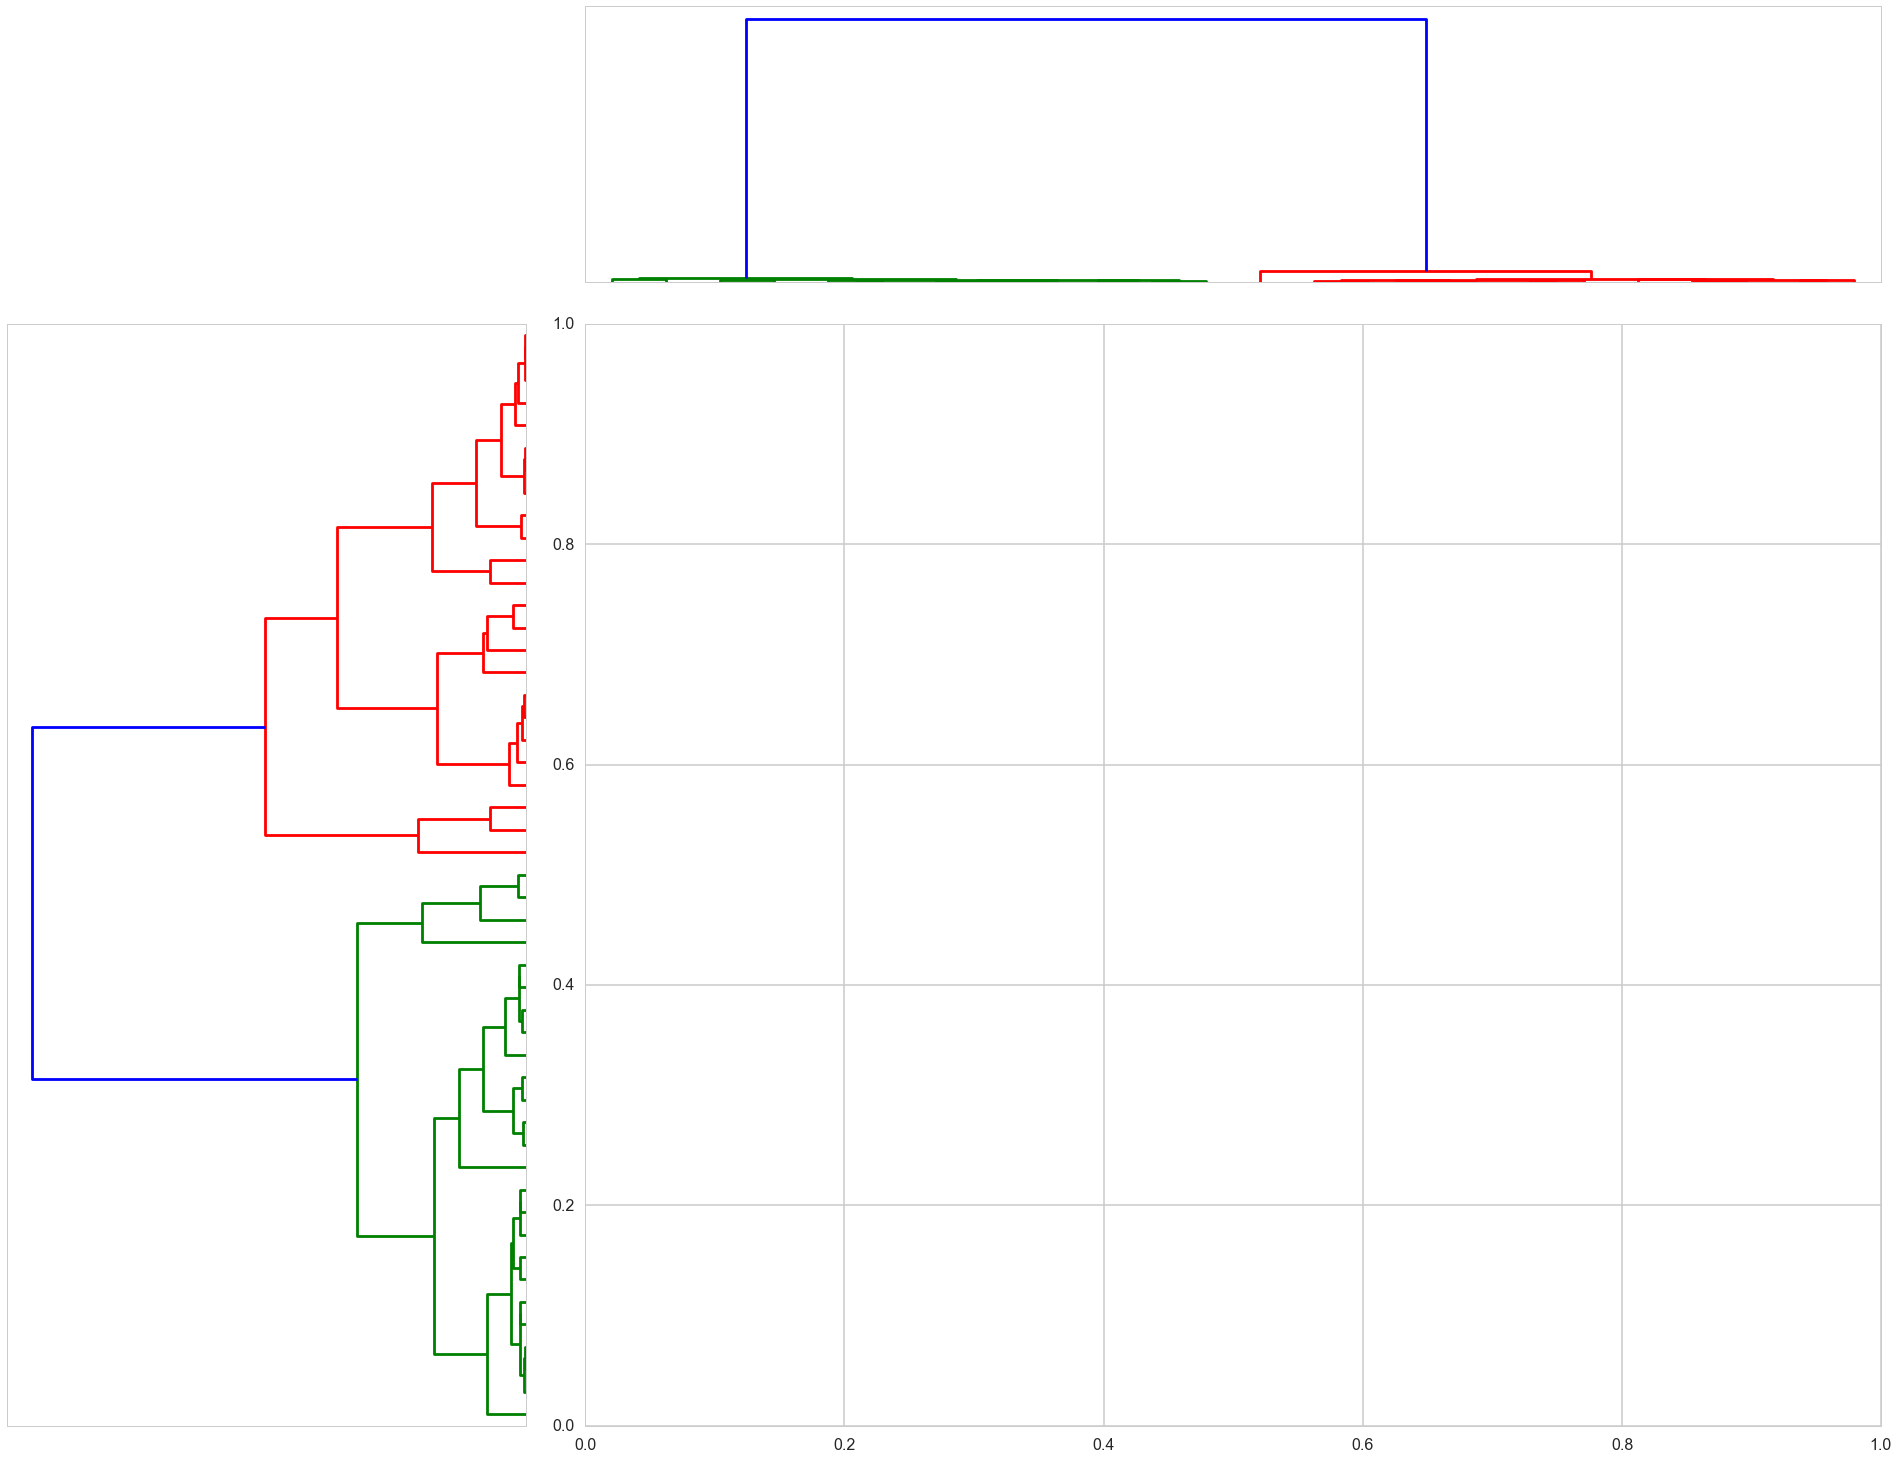

In [60]:
heatmap(mat.astype(float),list(LoadedDataLog[1:50].index), list(LoadedDataLog[1:50].columns), row_method = 'weighted', column_method= 'weighted', row_metric='correlation', column_metric='correlation',color_gradient='red_white_blue', filename='map')